# 6. Deep Learning for Text and Sequences

## Understanding Recurrent Neural Networks

The MLP and CNN have no memory. Each input is shown to them independently, with no state kept between inputs. These are considered <b>feed-forward networks</b>.

In contrast, in reading, when we process a word, we also keep a memory of what came before. This gives a fluid representation of the meaning conveyed by a sentence. A <b>recurrent neural network (RNN)</b> adopts the same principle (albeit a simplified version) It processes sequences by iterating through the sequence elements and maintaining a <b>state</b> containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop. The state of the RNN is reset between processing two different, independent sequences (e.g. two documents) so you still consider one sequence a single data point: a single input to the network. But the data point is no longer processed in a single step. Rather, the network internally loops over sequence elements.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb

from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Dense, SimpleRNN, LSTM)

Consider the following psuedocode for the RNN.

```python
state_t = 0
for input_t in input_seq:
    output_t = f(input_t, state_t)
    # the previous output becomes the input for the next iteration     
    state_t = output_t
```
This RNN takes as input a sequence of vectors of size `(timesteps, input_features)`. It loops over timesteps and at each timestep $t$, it considers its current state & input at $t$ and combines them to obtain the output at $t$. This is then the state for the computation at $t+1$. At $t=0$, the state is initialised as an all-zero vector. This is the <u>initial state</u> of the network.

We can even flesh out the function $f$ to be the transformation of the <u>input and state</u> to an output parameterised by two matrices and a bias vector.
```python
state_t = 0
for input_t in input_seq:
    # concretely defining f
    output_t = activation(dot(W, input) + dot(U, state_t) + b)
    # the previous output becomes the input for the next iteration     
    state_t = output_t
```

In [2]:
T = 100
# Dimensionality of input & output space, respectively
INPUT_FEATURES, OUTPUT_FEATURES = 32, 64

# Create the input as random noise, and state as a zero-vector
inputs = np.random.random((T, INPUT_FEATURES))
state_t = np.zeros((OUTPUT_FEATURES,))

# Randomly initialise weights
W = np.random.random((OUTPUT_FEATURES, INPUT_FEATURES))
U = np.random.random((OUTPUT_FEATURES, OUTPUT_FEATURES))
B = np.random.random((OUTPUT_FEATURES,))

successive_outputs = []

for input_t in inputs:
    # Perform the computation as a function of the input and state, with weights    
    output_t = 1/1+np.exp((np.dot(W, input_t) + np.dot(U, state_t) + B)*-1)
    successive_outputs.append(output_t)
    # Update the state at successive steps
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

The above is an implementation of an RNN layer. Essentially, it is a for loop that reuses quantities computed during the previous iteration of the loop. RNNs are characterised by the step function, in this case the sigmoid function.

The following is the graphical representation of the RNN.
<img src="img63.png" width="650">

In time $t$, the input to the layer is input $t$, state at $t$. The state at $t$ is the output from $t-1$, and following this, the output at $t$ is the state for $t+1$.

### A Recurrent Layer in Keras

The code implemented above corresponds to an actual Keras layer - the `SimpleRNN` layer. The difference is that `SimpleRNN` processes batches of sequences, not just 1 sequence as in the above. Hence, it takes in inputs of shape `(batch_size, time_step, input_features)` rather than just 2 inputs `(time_step, input_features)` only.

`SimpleRNN` can be run in 2 different modes: either the full sequences of successive outputs for each timestep to output a 3D tensor of shape `(batch_size, time_step, output_features)` or only the last output of shape `(batch_size, output_features)`. These two modes are controlled by the `return_sequences` parameter. 

In [6]:
# Only return the output at the last value of t
clear_session()
dummymodel1 = Sequential()
dummymodel1.add(Embedding(10000, 32))
dummymodel1.add(SimpleRNN(32, return_sequences=False))
dummymodel1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Return the full sequence at all values of t
clear_session()
dummymodel2 = Sequential()
dummymodel2.add(Embedding(10000, 32))
dummymodel2.add(SimpleRNN(32, return_sequences=True))
dummymodel2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


When several recurrent layers are stacked one on top of another, the intermediate layers always output the full sequence of outputs.

In [10]:
# Return the full sequence at all values of t
clear_session()
dummymodel3 = Sequential()
dummymodel3.add(Embedding(10000, 32))
dummymodel3.add(SimpleRNN(32, return_sequences=True))
dummymodel3.add(SimpleRNN(32, return_sequences=True))
dummymodel3.add(SimpleRNN(32, return_sequences=True))
dummymodel3.add(SimpleRNN(32)) # or return_sequences=False
dummymodel3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Let's now use the RNN on the IMDB movie review classification problem.

In [14]:
# Ingestion
###########
VOCABULARY_SIZE = 10000
DOCUMENT_MAX_LENGTH = 500
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCABULARY_SIZE)
x_train = sequence.pad_sequences(train_data, maxlen=DOCUMENT_MAX_LENGTH)
x_test = sequence.pad_sequences(test_data, maxlen=DOCUMENT_MAX_LENGTH)

In [17]:
# Instantiate Model
###################
clear_session()
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE, 32, input_length=DOCUMENT_MAX_LENGTH))
model.add(SimpleRNN(32, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Compile
#########
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# Train
#######
history = model.fit(x_train, train_labels, 
                    epochs=10, batch_size=128, 
                    validation_split=0.2,)

Epoch 1/10
157/157 [==============================] - 32s 202ms/step - loss: 0.2628 - accuracy: 0.9007 - val_loss: 0.3604 - val_accuracy: 0.8424
Epoch 2/10
157/157 [==============================] - 31s 198ms/step - loss: 0.2242 - accuracy: 0.9155 - val_loss: 0.3576 - val_accuracy: 0.8390
Epoch 3/10
157/157 [==============================] - 38s 240ms/step - loss: 0.1903 - accuracy: 0.9282 - val_loss: 0.3950 - val_accuracy: 0.8706
Epoch 4/10
157/157 [==============================] - 81s 516ms/step - loss: 0.1581 - accuracy: 0.9437 - val_loss: 0.3832 - val_accuracy: 0.8316
Epoch 5/10
157/157 [==============================] - 31s 199ms/step - loss: 0.1336 - accuracy: 0.9523 - val_loss: 0.5613 - val_accuracy: 0.7954
Epoch 6/10
157/157 [==============================] - 28s 178ms/step - loss: 0.1170 - accuracy: 0.9581 - val_loss: 0.4037 - val_accuracy: 0.8340
Epoch 7/10
157/157 [==============================] - 28s 175ms/step - loss: 0.0900 - accuracy: 0.9676 - val_loss: 0.4544 - val_ac

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.117034,0.95805,0.403654,0.8340,6
6,0.090023,0.96765,0.454417,0.8270,7
7,0.069094,0.97630,0.528686,0.8218,8
8,0.061685,0.97800,0.496493,0.8482,9
9,0.046570,0.98470,0.590590,0.8174,10


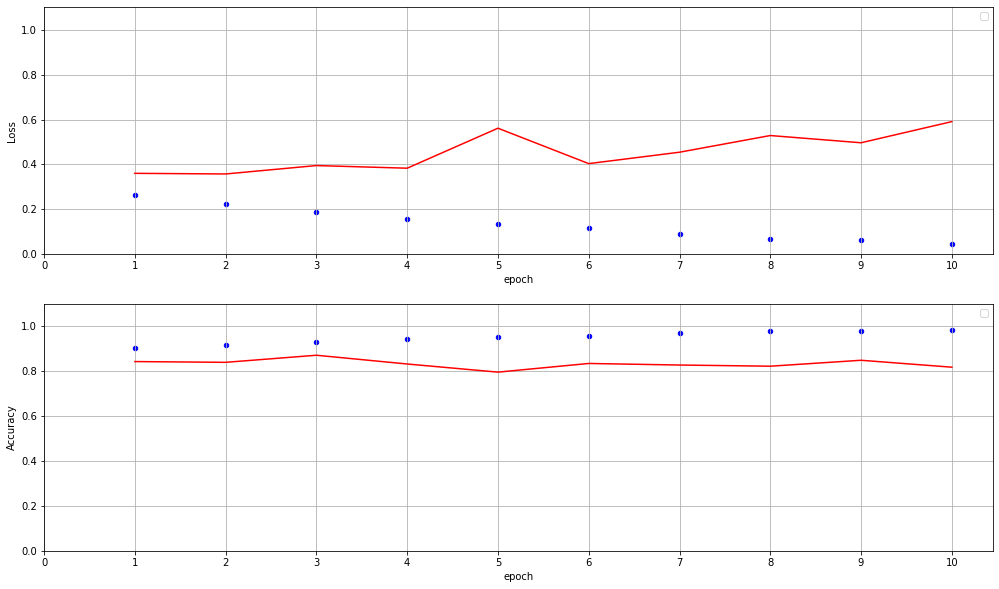

In [22]:
metrics_df = pd.DataFrame(history.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,11))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,11))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

In [23]:
model.evaluate(x_test, test_labels)

782/782 [==============================] - 28s 36ms/step - loss: 0.6037 - accuracy: 0.8120


[0.6036810278892517, 0.8120399713516235]

The first naive approach got us 88% accuracy. But this small recurrent network does not perform well against the baseline. The `SimpleRNN` is not good at processing long sequences, like text. But there are other types of recurrent layers that work on them.

### Understanding LSTM and GRU Layers

In practice, we hardly use the `SimpleRNN` and use `LSTM` or `GRU` layers. `SimpleRNN` has no ability to learn long-term dependencies due to the <b>vanishing gradient problem</b>, similar to what we observe in feedforward networks.

This is overcome using an `LSTM` layer. On top of the `SimpleRNN` computations, there is another data flow that carries information across steps, a carry, $C$. This will be combined with the input connection and recurrent connection. It extends the RNN psuedocode:

```python
output_t = activation(dot(state_t, Uo) + 
                      dot(input_t, Wo) + 
                      dot(C_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```

And then 
```python
c_{t+1} = i_t * k_t + c_t * f_t
```

Conceptually, `c_t * f_t` is to deliberately forget information that is irrelevant to the carry workflow. `i_t * k_t` provide information about the present, updating the carry track with new information. 

<img src="img64.png" width="700">

In [25]:
# Instantiate Model
###################
clear_session()
model2 = Sequential()
model2.add(Embedding(VOCABULARY_SIZE, 32, input_length=DOCUMENT_MAX_LENGTH))
model2.add(LSTM(32, return_sequences=False))
model2.add(Dense(1, activation='sigmoid'))

# Compile
#########
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
# Train
#######
history2 = model2.fit(x_train, train_labels, 
                    epochs=10, batch_size=128, 
                    validation_split=0.2,)

Epoch 1/10
157/157 [==============================] - 61s 387ms/step - loss: 0.5086 - accuracy: 0.7627 - val_loss: 0.3305 - val_accuracy: 0.8724
Epoch 2/10
157/157 [==============================] - 68s 434ms/step - loss: 0.2922 - accuracy: 0.8863 - val_loss: 0.3071 - val_accuracy: 0.8700
Epoch 3/10
157/157 [==============================] - 57s 365ms/step - loss: 0.2341 - accuracy: 0.9108 - val_loss: 0.2917 - val_accuracy: 0.8790
Epoch 4/10
157/157 [==============================] - 54s 345ms/step - loss: 0.1972 - accuracy: 0.9265 - val_loss: 0.4178 - val_accuracy: 0.8710
Epoch 5/10
157/157 [==============================] - 65s 417ms/step - loss: 0.1782 - accuracy: 0.9359 - val_loss: 0.3735 - val_accuracy: 0.8650
Epoch 6/10
157/157 [==============================] - 101s 642ms/step - loss: 0.1564 - accuracy: 0.9446 - val_loss: 0.3530 - val_accuracy: 0.8530
Epoch 7/10
157/157 [==============================] - 65s 415ms/step - loss: 0.1453 - accuracy: 0.9482 - val_loss: 0.3286 - val_a

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.156403,0.94460,0.352953,0.8530,6
6,0.145332,0.94825,0.328576,0.8892,7
7,0.131493,0.95385,0.390942,0.8666,8
8,0.117867,0.95775,0.360674,0.8626,9
9,0.108876,0.96265,0.399184,0.8742,10


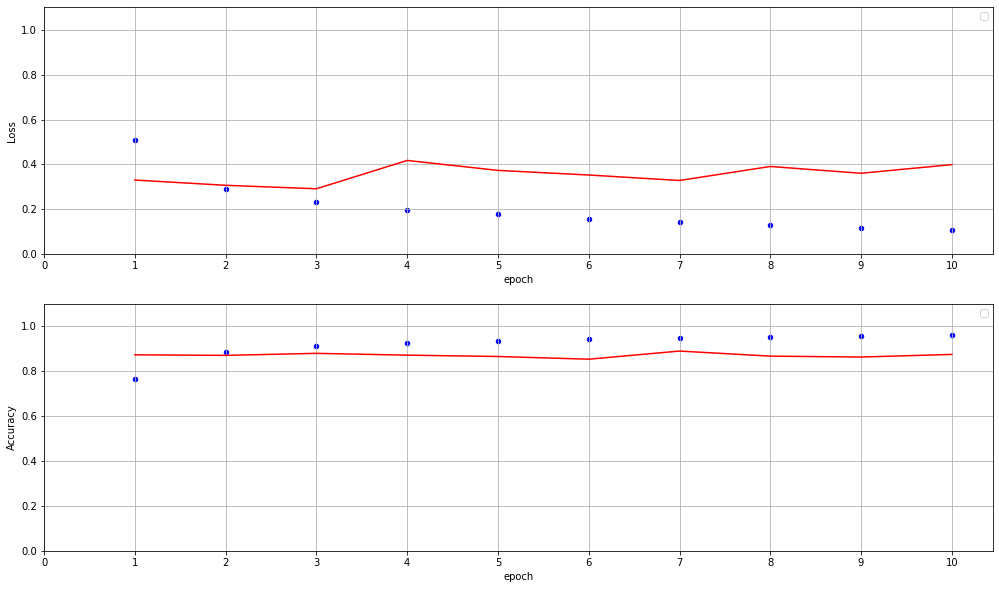

In [27]:
metrics_df = pd.DataFrame(history2.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,11))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,11))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

In [28]:
model2.evaluate(x_test, test_labels)

782/782 [==============================] - 46s 59ms/step - loss: 0.4358 - accuracy: 0.8637


[0.43575406074523926, 0.8636800050735474]

The validation accuracy has improved. That's because LSTM suffers less from the vanishing gradietn problem and slightly better than the fully connected approach in earlier chapters. But this result is not groundbreaking for something so computationally intensive. Why so? It could possibly be due to no tuning of hyperparameters, or lack of regularisation.

However, they primary reason is that analysing the global, long-term structure of the reviews is not helpful for a sentiment-analysis problem. This is well solved with bag-of-words models. But there are far more difficult natural-language processing problems out there where the strength of LSTM can be exploited. Examples are question-answering and machine translation.